# Home work 2 

[Dataset](https://www.kaggle.com/danielgrijalvas/movies/version/2)


## Evaluation

1. Preprocessing of dataset, explaination what column do you use, why, In you skip any column explain why. Please analize usage of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and/or [TF-IDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).You allow to use external sources. 
2. K-means. Find the best param: number of clusters `n_clusters` (train muptiple models choose the best one). Show that you trained at least two k-means models (train kmeans for dataset with features received by CountVectorizer/TF-IDF Vectorizer and without).
3. Visualize cluster for the best model (2D case, you are allowed to use t-SNE or PCA if you want, not compulsory though)
4. DBScan. Find the best params: epsilon `eps` and minimum number of samples `min_samples`(train muptiple models choose the best one). Show that you trained at least two dbscan models (train dbscan for dataset with features received by CountVectorizer/TF-IDF Vectorizer and without)
5. Visualize clusters for the best model (2D case, you are allowed to use t-SNE or PCA if you want, not compulsory though)
6. Summary for both approaches (describe the model accuracy, performance, score, etc.)

## Additional Info

Sklearn K-means class has property - `inertia_` sum of squared distances of samples to their closest cluster center. Could be used for comparison.

[Here](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py) is example how you can compare two clustering approaches

[Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)- method of interpretation and validation of consistency within clusters of data [from wiki](https://en.wikipedia.org/wiki/Silhouette_(clustering))

t-SNE - method to reduce the dimensionality down to 2 dimenions, check the [kaggle kernel](https://www.kaggle.com/ffisegydd/cluster-analysis-of-movies-data) for example

## Submit

Two options for submition: via email or on [distedu.ukma.edu.ua](https://distedu.ukma.edu.ua/course/view.php?id=32)

You should submit jupyter notebook by Sunday, November 18th till 11:55 pm EEST timezone.


## Bonus points

Hierarchical clustering. Find best params. Dendogram and explanation.
Try all four merge strategies (complete, average, single linkages and ward criteria)
(8 points)



# Step1: Initialization, reading input


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re 
import time

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
temp_data = pd.read_csv("movies.csv")


# Step2: Data exploration & preprocessing

### Simple exploration:

In [3]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
budget      6820 non-null float64
company     6820 non-null object
country     6820 non-null object
director    6820 non-null object
genre       6820 non-null object
gross       6820 non-null float64
name        6820 non-null object
rating      6820 non-null object
released    6820 non-null object
runtime     6820 non-null int64
score       6820 non-null float64
star        6820 non-null object
votes       6820 non-null int64
writer      6820 non-null object
year        6820 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


No nulls, everything except object-typed values seems OK.<br>
Let's check how many unique values each category has

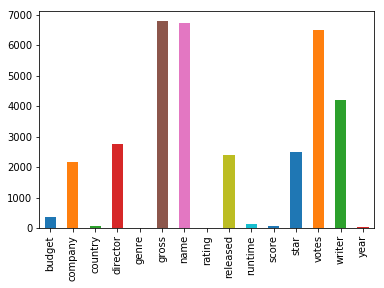

In [4]:
temp_data.nunique().plot.bar()

Some features have pretty low amount of unique values (genre, country, year). Others(vote, name, gross) are almost all unique.<br>
Let's look how unique values are distributed among different categories(company/country/genre/rating)

In [5]:
#"plotting+" func
def show_dist(series,title,threshold):
    temp,cnt,num = pd.Series(),0,0
    #not really effective, but the idea was to create that 'other' category
    for i in series.index:
        if series[i]<threshold:
            num+=series[i]
            cnt+=1
        else:
            temp[i]=series[i]
    temp['Other'] = num
    text = "Index 'Other' contains "+str(cnt)+" indexes"
    plt.figure(1,figsize=(8,8))
    plt.bar(temp.index,temp.values)
    plt.suptitle(title+'\n'+text)
    #plt.xlabel(text)
    plt.xticks(rotation='vertical')
    plt.show()

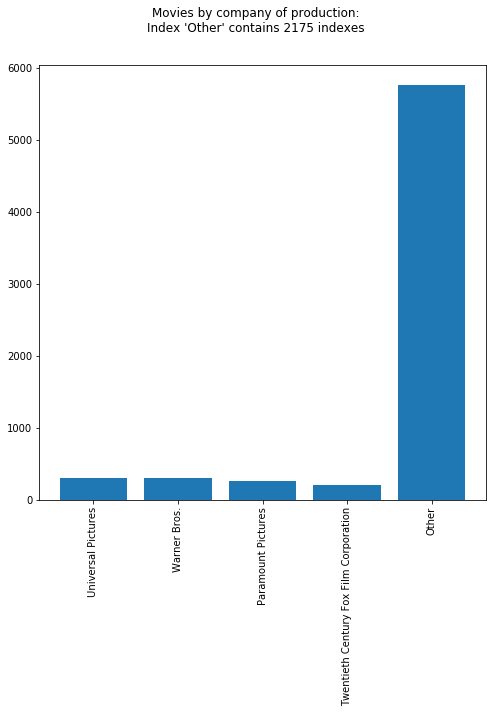

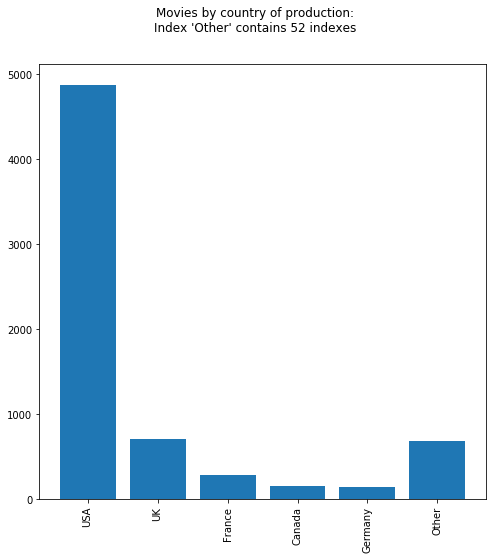

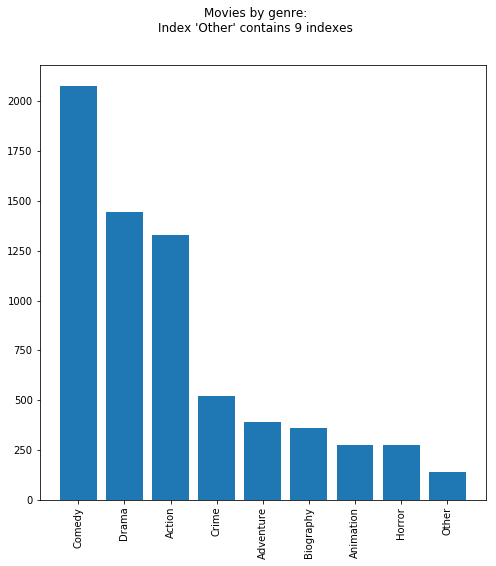

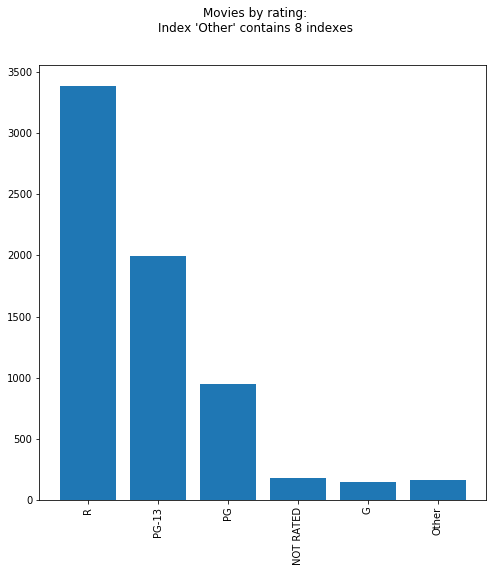

In [6]:
categories = [
    #category_name - category_description - threshold
    #threshold is chosen manually
    
    ["company","Movies by company of production:",200],
    ["country","Movies by country of production:",100],
    ["genre","Movies by genre:",100],
    ["rating","Movies by rating:",100]
]
for category in categories:
    naming,title, threshold = category    
    show_dist(temp_data[naming].value_counts(),title,threshold)
#Wasted 2 hours on this
#The next day I found same graphs in the dataset description on Kaggle. Ah, whatever..

As you may see, most features with relatively few categories (i.e. rating, genre) have a "dominant category", which sometimes consists of more elements than all other categories of that feature.<br>
Special category is a year, because all the values there are spread evenly<br>
Some numerical categories (especially, score, can be normalized and transformed into categories with discrete number of values 

In [7]:
#possibly useful normalization function
def normalize(dataframe,cols= ['budget','gross','runtime','score','votes']):
    temp = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dataframe[cols]))
    dataframe[cols] = temp
    return dataframe

In [8]:
#let's test a function. We'll be using: budget,gross,runtime,score,votes
#columns = ['budget','gross','runtime','score']
test_df_normalized = normalize(temp_data)
test_df_normalized.head()
#seems legit

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,0.026667,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,0.055823,Stand by Me,R,1986-08-22,0.123418,0.846154,Wil Wheaton,0.160690,Stephen King,1986
1,0.020000,Paramount Pictures,USA,John Hughes,Comedy,0.074879,Ferris Bueller's Day Off,PG-13,1986-06-11,0.167722,0.807692,Matthew Broderick,0.142194,John Hughes,1986
2,0.050000,Paramount Pictures,USA,Tony Scott,Action,0.191959,Top Gun,PG,1986-05-16,0.189873,0.692308,Tom Cruise,0.127244,Jim Cash,1986
3,0.061667,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,0.090919,Aliens,R,1986-07-18,0.275316,0.884615,Sigourney Weaver,0.290134,James Cameron,1986
4,0.030000,Walt Disney Pictures,USA,Randal Kleiser,Adventure,0.019820,Flight of the Navigator,PG,1986-08-01,0.126582,0.692308,Joey Cramer,0.019665,Mark H. Baker,1986


Certain columns should be tf-idf vectorized, others may simply be grouped by<br>
We won't group by 'director','star','writer'.In my opinion, it makes no sense:<br>
- firstly, I don't see any logic behind building tf-idf word matrices by person's separate name and surname. Imagine we have Tony Scott, Ridley Scott and Tony Kaye. Each of them is a director, shares name or surname with another, yet their movies are absolutely different. 
- secondly, there are simply too many unique values. Adding them all will extend our model with thousands of extra features of questionable quality.

In fact, I don't see any sense to group any column by words: let's look at a distribution of words met in a column "company" and then analyze a column "name": 

In [9]:
def explore_column_by_words(column,threshold=100):
    #adding something to pd.Series ain't efficient at all, but its a good way to generate a new words table step by step
    temp = pd.Series(temp_data[column].str.split())
    #small list of words to ignore
    stopwords = ["the","of","and","in","to","el","la","de","a","&","on","for","2","2:","3","4","5"]#I chose them myself
    words = pd.Series()
    for line in temp:
        for word in line:
            if word.lower() not in stopwords:
                word = re.sub("[^a-zA-Z]","",word)
                if word=="":
                    continue
                if word in words:
                    words[word]+=1
                else:
                    words[word]=1
    print("Total words:", words.count())
    print("Unique words:",words.nunique(),"\n\nWords by frequency:\n")
    print(words.sort_values(ascending=False))
    show_dist(words,"Words by frequency",threshold)


Total words: 2503
Unique words: 79 

Words by frequency:

Pictures             1838
Films                 801
Entertainment         720
Productions           606
Film                  474
Corporation           442
Fox                   337
Warner                306
Universal             305
Bros                  301
Columbia              282
Paramount             273
Century               220
Twentieth             212
New                   207
Cinema                192
Line                  186
Company               157
Touchstone            131
Disney                121
Walt                  116
Group                 105
MGM                   102
MetroGoldwynMayer     101
DreamWorks            101
Studios                88
TriStar                87
International          81
Screen                 79
Miramax                77
                     ... 
Casey                   1
Butchers                1
Goodspeed               1
Larger                  1
Babylon                 1
Prod  

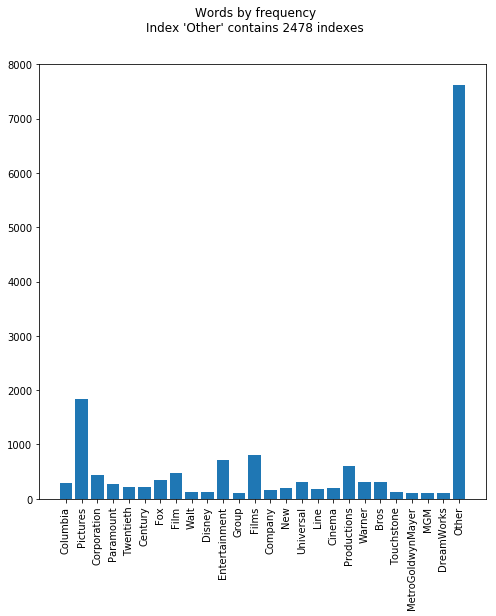

In [10]:
explore_column_by_words("company")

Most common words are "Pictures", "Films", "Entertainment", etc. Using tf-idf model by this words (in our task and current dataset) is senseless.<br>
Maybe the only suitable column will be 'name'

Total words: 6187
Unique words: 50 

Words by frequency:

Man             96
Love            81
My              68
I               66
Me              58
II              58
Movie           53
You             52
with            51
Dead            50
Night           49
Girl            43
Last            42
Life            41
Little          41
House           41
Black           37
Day             37
Big             36
American        35
Good            35
White           35
It              34
Mr              34
Men             33
World           32
Out             32
City            31
Is              31
Time            31
                ..
Bsico            1
letal            1
View             1
Paycheck         1
juegos           1
perversos        1
Matchstick       1
Elephant         1
Core             1
Mexico           1
McGuire          1
Lizzie           1
Holes            1
Daredevil        1
Machines         1
Italian          1
Revolutions      1
Dogville         1
Gentlemen  

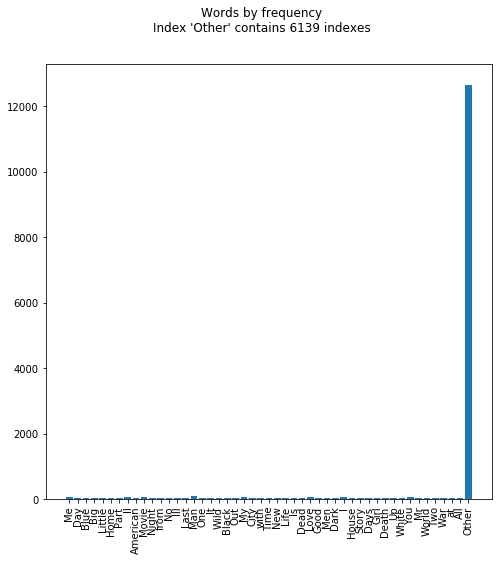

In [13]:
#we ignored some of the most typical words and set threshold at 30

explore_column_by_words("name",25)

### Feature engineering: naive approach
Primarily, we'll assume that we don't all text fields except for 'company'
We will generate bool features using get_dummies on 'genre' and 'rating':

In [36]:
#Preprocessing: cleaning the data set. 
temp_data = pd.read_csv("movies.csv")
#we just drop most of text values
temp_data.released = pd.to_datetime(temp_data.released)
temp_data.drop(['director','name','star','country','writer','released'],axis=1,inplace=True)

In [37]:
#creating dummies for groups where tf-idf/countvectorizer are pointless
temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.genre.astype('category'))],axis=1)
temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.rating.astype('category'))],axis=1)

temp_data.drop(['genre','rating'],axis=1,inplace=True)

In [16]:
#data_d - set with no vectorization except for genre&rating
data_d = temp_data.copy()
data_d.drop('company',axis=1,inplace=True)


For the sake of curiosity, we will use tf-idf vectorizer with 'company' (around 2.5k unique words).
We'll create additional dataframe for that. Also, we'll create a dataframe with 'company', vectorized by count-vectorizer. Then we'll run KMeans model on different dataframes and compare results using inertia


In [24]:
#TF IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    lowercase=True,
    token_pattern=r'\w{1,}',
    stop_words='english',
    max_features=2500,
    min_df = 1)

def tfidf_vectorize_feature(data,feature):
    v = tfidf_vectorizer.fit_transform(data[feature])
    tfidf_vect = pd.DataFrame(v.todense(), columns=tfidf_vectorizer.get_feature_names())
    temp = pd.concat([data, tfidf_vect], axis=1)
    temp.drop(feature,axis=1,inplace=True)
    return temp

In [23]:
#CountVectorizer
count_vectorizer = CountVectorizer(
    strip_accents='unicode',
    analyzer='word',
    lowercase=True,
    token_pattern=r'\w{1,}',
    stop_words='english',
    max_features=2500,
    min_df = 1)

def count_vectorize_feature(data,feature):
    c = count_vectorizer.fit_transform(data[feature])
    count_vect = pd.DataFrame(c.todense(),columns=count_vectorizer.get_feature_names())
    temp = pd.concat([data,count_vect], axis=1)
    temp.drop(feature,axis=1,inplace=True)
    return temp

In [42]:
#vectorize single feature
data_t = tfidf_vectorize_feature(temp_data,'company')
data_c = count_vectorize_feature(temp_data,'company')


# Step3: Building K-Means model.

In [26]:
#K-Means - different num of clusters
def kmeans_model(desc,clusters,data):
    inertia = []
    print(desc)
    for i in range(2,clusters+1):
        model = KMeans(n_clusters=i)
        model.fit(data)
        inertia.append(model.inertia_)
        if i%10==0:
            print("Inertia on {} clusters: {}".format(i,model.inertia_))
    return inertia

### "almost no text features" approach

In [44]:
#runs ~40mins(i5-7300HQ), inertia on every set is very similar and giant (around 1.3*10^18 for 20 clusters)
stats_d = kmeans_model("Starter, only dummies",50,data_d)#runs in couple minutes
stats_t = kmeans_model("Starter with dummies, tf-idf-ized 'company'",50,data_t)
stats_c = kmeans_model("Starter with dummief, countv-ized 'company'",50,data_c)

Starter with dummies, tf-idf-ized 'company'
Inertia on 10 clusters: 2.7484860688811126e+18
Inertia on 20 clusters: 1.3325447011389642e+18
Inertia on 30 clusters: 8.614824405600724e+17
Inertia on 40 clusters: 6.403562908464607e+17
Inertia on 50 clusters: 5.0286967614973037e+17
Starter with dummief, countv-ized 'company'
Inertia on 10 clusters: 2.749849066197541e+18
Inertia on 20 clusters: 1.3330596587224942e+18
Inertia on 30 clusters: 8.707042343487918e+17
Inertia on 40 clusters: 6.274067966952358e+17
Inertia on 50 clusters: 4.969134127733565e+17


### Feature engineering: everything featurized*

*everything but 'released'

In [50]:
#data preparation
def prepare_dataset():
    temp_data = pd.read_csv("movies.csv")  
    #temp_data.released = pd.to_datetime(temp_data.released)
    #temp_data[['r_year','r_month','r_day']] = temp_data.released.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

    #getting dummies from smaller categories
    temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.genre.astype('category'))],axis=1)
    temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.rating.astype('category'))],axis=1)
    temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.year.astype('category'))],axis=1)    
    #temp_data = pd.concat([temp_data,pd.get_dummies(temp_data.r_year.astype('category'))],axis=1)
    
    temp_data.drop(columns=['released','genre','rating','year'],axis=1,inplace=True)
    return temp_data

In [28]:
features = ['company','country','director','name','star','writer']
data_tfd = prepare_dataset()

for f in features:
    data_tfd = tfidf_vectorize_feature(data_tfd,f)

In [45]:
stats_all_vect = kmeans_model("Starter, all features vectorized",50,data_tfd)

Starter, all features vectorized
Inertia on 10 clusters: 2.748529066997636e+18
Inertia on 20 clusters: 1.3400117916318536e+18
Inertia on 30 clusters: 8.716580992446927e+17
Inertia on 40 clusters: 6.414107928381722e+17
Inertia on 50 clusters: 5.044264970147402e+17


### more adequate approach:

Now lets repeat 2 previous approaches with normalized features:


In [ ]:
data_tfd_normalized = normalize(prepare_dataset)
for f in features:
    data_tfd_normalized = tfidf_vectorize_feature(data_tfd_normalized,f)


In [ ]:
data_tfd_normalized.head()

In [46]:
stats_tfd_normalized = kmeans_model("Normalized set",50,data_tfd_normalized) #runs for another 30 mins.

Normalized set
Inertia on 10 clusters: 27963.21365206909
Inertia on 20 clusters: 26670.18770438666
Inertia on 30 clusters: 25839.625499081725
Inertia on 40 clusters: 25523.85550936234
Inertia on 50 clusters: 25191.060694315413


In [54]:
#let's try scaler instead of our normalization
data = prepare_dataset()
for f in features:
    data = tfidf_vectorize_feature(data,f)

pipeline = Pipeline([('scale', StandardScaler())])
tfd_scaled = pipeline.fit_transform(data)

In [ ]:
stats_tfd_scaled = kmeans_model("StandardlyScaled set",50,data_tfd_normalized)

StandardlyScaled set
Inertia on 10 clusters: 27823.169699275626
Inertia on 20 clusters: 26602.967411147692


In [ ]:
plt.figure(1,figsize=(12,12))
plt.plot(stats_d,label='only dummies')
plt.plot(stats_t,label='only one feature tf-idf-ized')
plt.plot(stats_c,label='only one feature tf-idf-ized')

plt.plot(stats_all_vect,label="all features vectorized")
plt.plot(stats_tfd_normalized,label='all features vectorized and normalized')
plt.plot(stats_tfd_scaled,label='all features vectorized and scaled standardly')

plt.legend()

Via elbow method, `n_clusters` = 4 seems optimal

In [ ]:
plt.plot(stats_tfd_normalized,label='all features vectorized and normalized')
plt.plot(stats_tfd_scaled,label='all features vectorized and scaled standardly')
plt.legend()

## Visualization: t-SNE

we'll use plotly

In [ ]:
def perform_tsne(clusters,data):
    model = KMeans(n_clusters=clusters)
    model.fit(data)
    start = time.time()
    pred = model.fit_predict(data)
    t1 = time.time()-start #seconds to compute pred
    print("tsne fitted in {} seconds".format(t1))
    tsne = TSNE()#default components num
    start = time.time()
    tsne_fit = tsne.fit_transform(data)
    t2 = time.time()-start()#seconds to fit-transform via t-SNE
    print("tsne fitted in {} seconds".format(t2))
    plot_tsne

In [ ]:
init_notebook_mode(connected=True)
def plot_tsne(fit,pred):#pred is for colors
    
    trace = go.Scatter(
        x=tsne_fit.T[0], 
        y=tsne_fit.T[1],
        mode='markers',
        text=name,
        textposition='top center',
        name='Lines, Markers and Text',
        marker=dict(
            color = pred, 
            colorscale='Portland',
            showscale=True
        )
        vis_data = [trace]
    layout = go.Layout(
    showlegend=False)
    visualization = go.Figure(data=data, layout=layout)
    iplot(visualization)

# Step 4: DBScan

## Visualization: PCA

# Summary

# Bonus: Hierarchical clustering

In [71]:
#cluster visualization for rbest
#DBscan, visualization
#Summary
